# 	ラボ9 検索アルゴリズムとしての量子シミュレーション

前提知識:

- [Ch.3.8 グローバーのアルゴリズム](/course/ch-algorithms/grovers-algorithm)
- [Ch.2.5 普遍性の証明](/course/ch-gates/proving-universality)

その他の関連資料:

- [QCQIのCh 6.2] Michael A. NielsenとIsaac L. Chuang著 量子計算と量子情報、p255

In [1]:
from qiskit import *
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_state_qsphere, plot_histogram

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [2]:
sim = Aer.get_backend('qasm_simulator')

## パート1：ハミルトニアン・シミュレーション


**ゴール**

このラボでは、与えられたハミルトニアンによって生成された発展の過程として見られる量子状態への変化を考えます。ハミルトニアンが決まると、対応して任意の初期状態に対して終状態を決定するユニタリー演算子が存在することになります。
初期状態 $|\psi(0)\rangle$ および時間に依存しないハミルトニアン$H$の場合、終状態 $|\psi(t)\rangle$ は $|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$ です。したがって、ユニタリー演算子 $e^{-iHt}$ を適切なゲートで構築することにより、量子状態 $|\psi\rangle$ の発展をシミュレートする量子回路を構築することができます。

### 1. 与えられたハミルトニアンに対して、量子回路を構築します。

ハミルトニアン $H$ と系の初期状態 $|\psi(0)\rangle$ は、次の式で与えられます。

$H = |0\rangle\langle0| + |+\rangle\langle+|, ~~~~ |\psi(0)\rangle = |+\rangle = \frac{1}{\sqrt 2}(|0\rangle + |1\rangle)$.

状態 $|\psi(0\rangle$ を時間 $\Delta t = \theta$ 間に $H$ で発展させるために2量子ビットで回路を構築します。ここで系の状態は0番目の量子ビットでエンコードされ、1番目の量子ビットは補助ビットになります。そして終状態 $|\psi(\theta)\rangle$ は $|\psi(\theta)\rangle = e^{-i\theta ~ ( |0\rangle\langle0| ~ + ~ |+\rangle\langle+| )}~|\psi(0)\rangle$ です。

#### 📓ステップA. 系の状態は0番目の量子ビットにエンコードされ、補助ビットである1番目の量子ビットは $|0\rangle$ 状態にセットされているとき、次の回路のゲートH1が、0番目の量子ビットに対して演算 $e^{-i\frac{\pi}{9}|0\rangle\langle0|}$ を行うことを示してください。

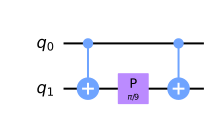

In [3]:
h1 = QuantumCircuit(2, name = 'H1')

h1.cnot(0, 1)
h1.p(np.pi/9, 1)
h1.cnot(0, 1)

H1 = h1.to_gate()

h1.draw()

**あなたの回答**:


#### 📓ステップB. 系の状態は0番目の量子ビットにエンコードされ、補助ビットである1番目の量子ビットは $|0\rangle$ 状態にセットされているとき、次のコードを完成させて回路`h2`におけるゲートH2を構築し、0番目の量子ビットに対して操作 $e^{-i\frac{\pi}{9}|+\rangle\langle+|}$ を行うようにしてください。

In [4]:
h2 = QuantumCircuit(2, name='H2')

#### Your code goes here ###







#############################

H2 = h2.to_gate()

h2.draw()

### 2.以下のセルを実行して反復ごとに0番目の量子ビットの状態を生成してください。

この回路は0番目の量子ビットに $(H1H2)^7|+\rangle = ( e^{-i\frac{\pi}{9}  |0\rangle\langle0|}e^{-i\frac{\pi}{9}|+\rangle\langle+|} )^7|+\rangle$ を適用します。各`H1H2`演算後の0番目の量子ビットの状態は、リスト変数「myst」に格納されます。

In [1]:
from qiskit.quantum_info import Statevector, partial_trace

def st_out(qc):
    out = Statevector.from_instruction(qc)
    out_red = partial_trace(out, [1])
    prob, st_all = la.eig(out_red.data)
    cond = (prob>0.99) & (prob<1.01)
    st = st_all[:, cond].ravel()
    
    return(st)
    
myst = []

circ = QuantumCircuit(2)
circ.h(0)
st = st_out(circ)
myst.append(Statevector(st))

for _ in range(7):
    circ.append(H1, range(2))
    circ.append(H2, range(2))
    st = st_out(circ)
    myst.append(Statevector(st))
    
circ.draw() 

次のブロッホ球の図は、0番目の量子ビット状態の発展を示しています。図のように、状態は $|+\rangle$ 状態から始まり、$|0\rangle$ 状態に向かって回転し、通過します。したがって、 `H1`および`H2`演算の角度を適切に設定すると、$H1H2 = e^{-i\theta ~ |0\rangle\langle0|}e^{-i\theta~|+\rangle\langle+|}$ を適切な回数作用させることで、$|+\rangle$ 状態は発展して $|0\rangle$ になります。 

<img src="images/L9_bloch_sphere.png" alt="Drawing" width="300">

`kaleidoscope`をインストールしたか、このラボを[IQX](https://quantum-computing.ibm.com)で実行した場合は、下のセルを実行して、インタラクティブなブロッホ球を介して状態発展を視覚化できます。 

In [11]:
from kaleidoscope import bloch_sphere
from matplotlib.colors import LinearSegmentedColormap, rgb2hex

cm = LinearSegmentedColormap.from_list('graypurple', ["#999999", "#AA00FF"])
vectors_color = [rgb2hex(cm(kk)) for kk in np.linspace(-1,1,len(myst))]
bloch_sphere(myst, vectors_color = vectors_color)

## パート2：量子シミュレーションとしての量子検索


**ゴール**

ラボのこの節では、量子シミュレーションを通じて探索問題を解決していきます。

パート1では、ハミルトニアン $H$ の構造が $ H =|\psi_j\rangle\langle\psi_j| + |\psi_i\rangle\langle\psi_i| $ のように $|\psi_i\rangle$ と $|\psi_j\rangle$ の両者の状態に依存する場合、ハミルトニアンは $|\psi_i\rangle$ を $|\psi_j\rangle$ へと適切なタイムスパンで状態を変えることを示しました。

一意な解を持つ探索問題を考えると、グローバーのアルゴリズムと同様に、すべての取り得る要素を重ね合わせ状態 $|\psi\rangle$ にエンコードして初期状態として与えられる場合、ハミルトニアン $ H = |x\rangle\langle x| + |\psi\rangle\langle\psi|$ の形  で解を求めることができるはずです。ここで $|x\rangle$ は未知の解を表します。

ユニタリー演算子 $U = e^{-iH\Delta t}$ を初期状態 $|\psi\rangle$ に適切に選択された $\Delta t$ で正しい回数適用すると、状態 $|\psi\rangle$ は $|x\rangle$ に発展する、または十分に近い状態になるはずです。以下のコードは探索問題のオラクルゲートを構築しています。以下のセルを実行してください。 

In [4]:
n = 5
qc = QuantumCircuit(n+1, name='Oracle')
qc.mct(list(range(n)), n)

Oracle = qc.to_gate()

以下の回路は5番目の量子ビットを補助ビットとして使い、位相キックバックすることで、解の状態には位相 $\pi$ をエンコードし、その他の状態には何もしません。したがって、回路の出力状態は $(|\psi\rangle - |x\rangle) + e^{i\pi}|x\rangle$ であり、各基底状態の位相を色で表現するqsphereプロットを使うことで視覚的に確認することが出来ます。次の2つのセルを実行してください。 

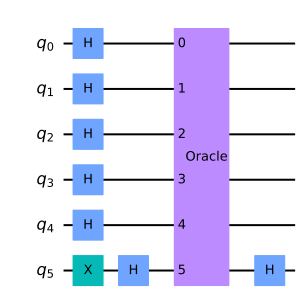

In [5]:
test = QuantumCircuit(n+1)
test.x(n)
test.h(range(n+1))
test.append(Oracle, range(n+1))
test.h(n)

test.draw()

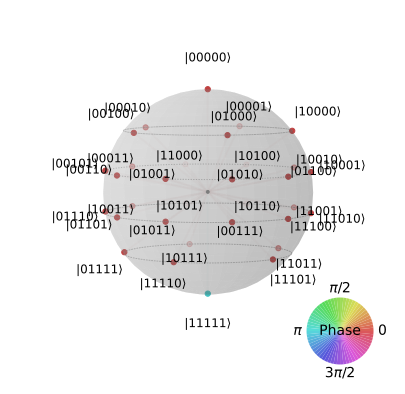

In [6]:
st = Statevector.from_instruction(test)
st_red = partial_trace(st, [5])

plot_state_qsphere(st_red)

### 1. ハミルトニアン $H = |x\rangle\langle x| + |\psi\rangle\langle\psi|$ を近似する回路を作成してください。このときすべての取り得る要素が重ね合わせ状態 $|\psi\rangle$ でエンコードされて初期状態として与えられ、$|x\rangle$ は一意な未知の解を表しています。

パート1で行ったように、ハミルトニアンを使用してシミュレーション用の回路を構築しますが、問題のすべての項目を調べるために、より多くの量子ビットを使用します。 32個のうち1つの解を持つ探索問題を考えてください。 

#### 📓ステップA. 次のコードを完成させて、操作 $e^{-i\Delta t|\psi\rangle\langle\psi|}$ を実行するゲートH1を構築してください。

In [7]:
def H1(delt, n=5):
    
    h1 = QuantumCircuit(n+1, name='H1')

    #### Your code goes here ######

    



    
    ###############################
    
    return h1.to_gate()

#### 📓ステップB. 次のコードを完成させて、操作 $e^{-i\Delta t|x\rangle\langle x|}$ を実行するゲートH2を構築してください。

In [8]:
def H2(delt, n=5):
    
    h2 = QuantumCircuit(n+1, name='H2')

    #### Your code goes here ######

    
    
    
    
    
    
    
    ###############################
    
    return h2.to_gate()

#### 📓ステップC. $e^{-i \pi H_{app}}|\psi\rangle = (e^{-i\pi|x\rangle\langle x|}e^{-i\pi|\psi\rangle\langle\psi|})|\psi\rangle $ を計算する回路'sim_h'を作成してください。この回路はハミルトニアン $H = |x\rangle\langle x| + |\psi\rangle\langle\psi|$、タイムスパン $\Delta t = \pi$ の下で状態 $|\psi\rangle$ を発展させます。

状態 $|\psi\rangle$ は、すべての取り得る要素の重ね合わせ状態を表します。

ゲート`H1`と`H2`を利用します。 

In [2]:
#### Your code goes here ####








############

sim_h.draw()

### 2.グローバーのアルゴリズムと $U = e^{-i\Delta t~H_{appr}}$ ($\Delta t = \pi$)が同一であることを検証することで、$H_{appr}$ を使用した量子シミュレーションで探索問題を解決できることを示してください。


#### ステップA. 以下の回路`grover`は、問題に対してグローバーのアルゴリズムを実行して、上記で構築したオラクルの解を見つけます。下のセルを実行してください。
 

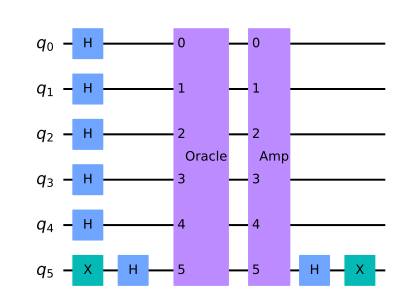

In [9]:
qc = QuantumCircuit(n+1, name='Amp')
qc.h(range(n))
qc.x(range(n))
qc.mct(list(range(n)), n)
qc.x(range(n))
qc.h(range(n))

Amp = qc.to_gate()

grover = QuantumCircuit(n+1)
grover.x(n)
grover.h(range(n+1))
grover.append(Oracle, range(n+1))
grover.append(Amp, range(n+1))
grover.h(n)
grover.x(n)

grover.draw()

#### ステップB. 以下のセルを実行すると、結果は回路「grover」と「sim_h」がグローバル位相まで同一であることを示しています。

In [8]:
st_simh = Statevector.from_instruction(sim_h)
st_grover = Statevector.from_instruction(grover)
print('grover circuit and sim_h circuit genrate the same output state: ' ,st_simh == st_grover)

In [9]:
plot_state_qsphere(st_simh)

In [10]:
plot_state_qsphere(st_grover)

#### 📓ステップC. 構築したオラクルの解を見つけるために必要なグローバーの繰り返しの数Rを見つけます。

In [3]:
#### your code goes here ####




######
print(R)

#### ステップD. グローバーのアルゴリズムとシミュレーション計算 $e^{-i R\pi H_{app}}|\psi\rangle = (e^{-i\pi|x\rangle\langle x|}e^{-i\pi|\psi\rangle\langle\psi|})^R|\psi\rangle $ (Rは反復回数)により、構築したオラクルを使って探索問題の解を見つけてください。

In [4]:
## The circuit to solve the search problem through Grover's algorithm. 
n = 5 

qc_grover = QuantumCircuit(n+1, n)
qc_grover.x(n)
qc_grover.h(range(n+1))
for _ in range(int(R)):
    qc_grover.append(Oracle, range(n+1))
    qc_grover.append(Amp, range(n+1))

qc_grover.h(n)
qc_grover.x(n)
qc_grover.barrier()
qc_grover.measure(range(n), range(n))


qc_grover.draw()

📓シミュレーションを通じて探索問題を解決するために、回路を構築するためのコード`qc_sim`を完成させてください。

In [5]:
qc_sim = QuantumCircuit(n+1, n)
qc_sim.h(range(n))

#### Your code goes here ####








次のセルを実行して、 `qc_grover`と`qc_sim`の両方の回路をシミュレートし、それらの解を比較します。

In [6]:
counts = execute([qc_grover, qc_sim], sim).result().get_counts()
plot_histogram(counts, legend=['Grover', 'Hamiltonian'])

### 3. 以下の結果は、適切な期間 $\Delta t$ を選択することにより、量子シミュレーションによって1に正確に等しい確率で解を見つけることができる例を示しています。

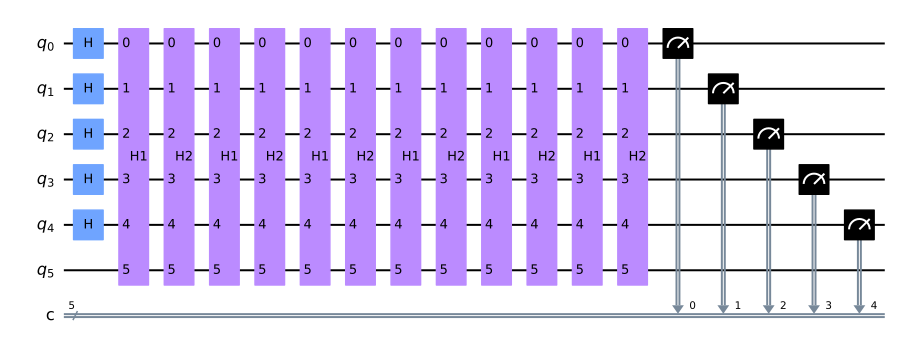

In [10]:
n = 5

qc = QuantumCircuit(n+1, n)
qc.h(range(n))

delt, R = np.pi/2.1, 6

for _ in range(int(R)):
    qc.append(H1(delt), range(n+1))
    qc.append(H2(delt), range(n+1))

qc.measure(range(n) ,range(n))    
qc.draw()

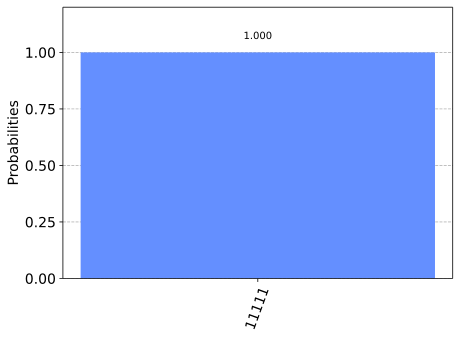

In [11]:
count = execute(qc, sim).result().get_counts()
plot_histogram(count)